In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({
    'savefig.dpi': 300, 
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "lines.linewidth": 0.8,
})

cm = 1/2.54  # centimeters in inches

Initial Distance Estimation Based on Dispersion Measure

In [2]:
from psrqpy import QueryATNF

# get pulsar that is nearby
c = ['18:32:58.4', '-09:11:15.4', 10.]
query = QueryATNF(params=['JNAME', 'RAJ', 'DECJ', "DIST_DM", "DIST_A"], circular_boundary=c)

In [6]:
df = query.table.to_pandas()
cleandf = df[~df["DIST_A"].isna()]

# calculate relative errors
relative_errs = (cleandf["DIST_A"] - cleandf["DIST_DM"]) / cleandf["DIST_A"]
relative_errs = relative_errs.to_numpy()

# those sources are within the globular cluster, we will ignore them
cleandf = cleandf[(cleandf["DIST_A"] != 9.23) & (cleandf["DIST_A"] != 8.16) & (cleandf["DIST_A"] != 7.48)]

relative_errs = (cleandf["DIST_A"] - cleandf["DIST_DM"]) / cleandf["DIST_A"]
relative_errs = relative_errs.to_numpy()

print("standard deviation of relative errors: ", np.nanstd(relative_errs))

standard deviation of relative errors:  0.35881144037272555


Distance Constraints on HI absorption

Credit: Joanne Dawson

In [8]:
import csv
from astropy import convolution as con

In [11]:
# Define a few useful functions
# thingy to read in a CARTA-exported spectrum and output a 2D numpy array

# read in spectra output from CARTA
def readCartaSpec(tsv_filename, hdlines=6):
    
    vlist=[]
    slist=[]
    with open(tsv_filename, 'r') as file:
        reader = csv.reader(file, delimiter = '\t')
        for i in range(hdlines): next(reader) # skip header
        for row in reader:
            vlist.append(float(row[0]))
            slist.append(float(row[1]))
    thingo=np.array([vlist,slist])
    return(thingo)

# generate e^-tau spectrum
def convertToEtau(absSpec, blankv0, blankv1):
    ind1=np.where(np.abs(absSpec[0]-blankv0) == np.min(np.abs(absSpec[0]-blankv0)))[0][0]
    ind0=np.where(np.abs(absSpec[0]-blankv1) == np.min(np.abs(absSpec[0]-blankv1)))[0][0]
    meanAbsSpecCont = np.mean(np.concatenate((absSpec[1,0:ind0],absSpec[1,ind1:])))
    return np.array([absSpec[0],absSpec[1]/meanAbsSpecCont]) 

# return 2D array with axis, positive envelope, negative envelope, 3sigmas of each
def computeNoiseEnvelope(absSpec, emSpec, blankv0, blankv1, Tsys, eta_mb=1.0):
    ind1=np.where(np.abs(absSpec[0]-blankv0) == np.min(np.abs(absSpec[0]-blankv0)))[0][0]
    ind0=np.where(np.abs(absSpec[0]-blankv1) == np.min(np.abs(absSpec[0]-blankv1)))[0][0]
    sigmaAbsSpecCont = np.std(np.concatenate((absSpec[1,0:ind0],absSpec[1,ind1:])))
    meanAbsSpecCont = np.mean(np.concatenate((absSpec[1,0:ind0],absSpec[1,ind1:])))
    sigmaAbsSpecPos = meanAbsSpecCont+sigmaAbsSpecCont * ((emSpec[1,:]*eta_mb+Tsys)/Tsys)
    sigmaAbsSpecNeg = meanAbsSpecCont-sigmaAbsSpecCont * ((emSpec[1,:]*eta_mb+Tsys)/Tsys)
    sigma3AbsSpecPos = meanAbsSpecCont+3*sigmaAbsSpecCont * ((emSpec[1,:]*eta_mb+Tsys)/Tsys)
    sigma3AbsSpecNeg = meanAbsSpecCont-3*sigmaAbsSpecCont * ((emSpec[1,:]*eta_mb+Tsys)/Tsys)
    
    return np.array([emSpec[0],sigmaAbsSpecPos,sigmaAbsSpecNeg,sigma3AbsSpecPos,sigma3AbsSpecNeg]) 

In [12]:
# Read in spectra, do a manual velocity shift on the GMRT one
absSpecBeam = readCartaSpec('../data/radio_HI/contcube-500_cln_beam_ON_redo.tsv')
absSpecBeamGMRT = readCartaSpec('../data/radio_HI/GMRT_nocln_beam_ON.tsv')
absSpecBeamGMRT[0,:]=absSpecBeamGMRT[0,:]-20.9
emSpec = readCartaSpec('../data/radio_HI/hi4pi_spectrum_1degbeam_vrad.tsv')

# Initial smoothing of the emission spectrum to roughly match the resolution of the
# MeerKAT data
fwhm_factor = np.sqrt(8*np.log(2))
gaussKern = con.Gaussian1DKernel(4.3/fwhm_factor)
emSpecSmth = emSpec.copy()
emSpecSmth[1] = con.convolve(emSpecSmth[1], gaussKern, boundary='wrap')

# Set out assumptions needed for tne noise envelope calculation
# This is the most conservative we can do it -- big HI noise envelope

Tsys_over_eta = 20.0
Tcont = 17.0
#eta = 0.75
eta_mb = 1.0

Tsys=Tsys_over_eta+Tcont

# Define velocity range with no HI signal and convert absorption spectra to e^-tau
blankv0=-75.0
blankv1=200.0
absSpecBeamGMRTEtau=convertToEtau(absSpecBeamGMRT,blankv0,blankv1)
absSpecBeamEtau=convertToEtau(absSpecBeam,blankv0,blankv1)

# More smoothing for the MeerKAT data and the emission data we're using for its noise
# envelope
boxKern = con.Box1DKernel(5)
boxKernEm = con.Box1DKernel(20)
absSpecBeamEtauSmth = absSpecBeamEtau.copy()
absSpecBeamEtauSmth[1] = con.convolve(absSpecBeamEtau[1], boxKern, boundary='wrap')
emSpecSmthMore = emSpecSmth.copy()
emSpecSmthMore[1] = con.convolve(emSpecSmthMore[1], boxKernEm, boundary='wrap')

# Noise envelope for smoothed MeerKAT data
envelopesBeamEtauSmth=computeNoiseEnvelope(absSpecBeamEtauSmth, emSpecSmthMore, blankv0, blankv1, Tsys, eta_mb=eta_mb)

# Simple mean and 3-sigma for GMRT data
ind1=np.where(np.abs(absSpecBeamGMRT[0]-blankv0) == np.min(np.abs(absSpecBeamGMRT[0]-blankv0)))[0][0]
ind0=np.where(np.abs(absSpecBeamGMRT[0]-blankv1) == np.min(np.abs(absSpecBeamGMRT[0]-blankv1)))[0][0]
sigmaGMRTEtau = np.std(np.concatenate((absSpecBeamGMRTEtau[1,0:ind0],absSpecBeamGMRTEtau[1,ind1:])))
meanGMRTEtau = np.mean(np.concatenate((absSpecBeamGMRTEtau[1,0:ind0],absSpecBeamGMRTEtau[1,ind1:])))


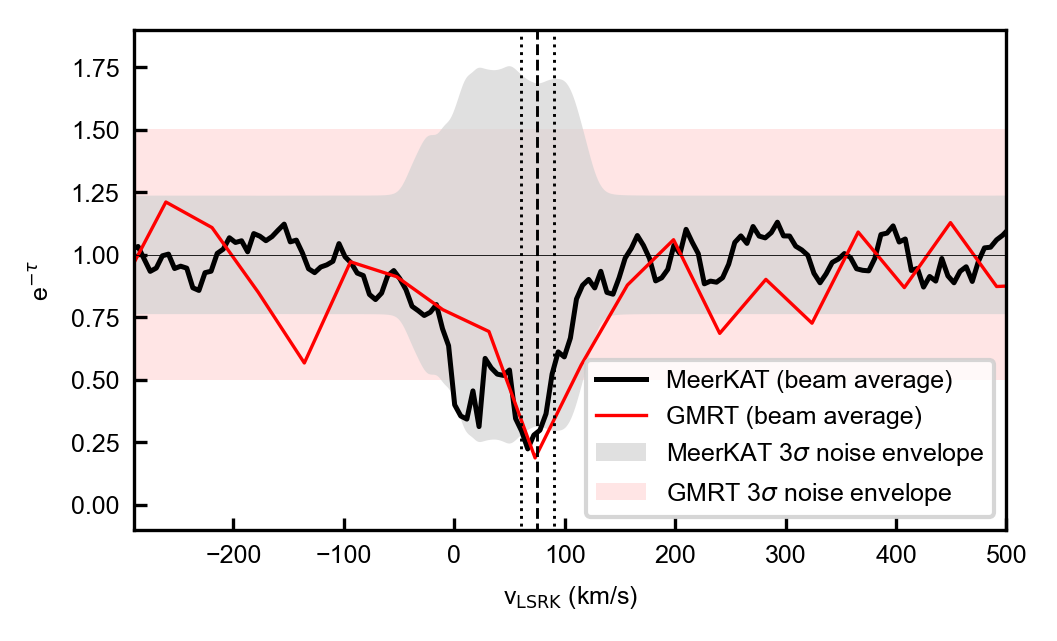

In [23]:
fig = plt.figure(figsize=(8.9*cm, 5.5*cm))
ax1 = fig.add_axes([0.12, 0.15, 0.83, 0.77])
im=ax1.plot(absSpecBeamEtauSmth[0,:],absSpecBeamEtauSmth[1,:],color='black',linewidth='1.2', label='MeerKAT (beam average)')
ax1.plot(absSpecBeamGMRTEtau[0,:],absSpecBeamGMRTEtau[1,:],color='red',linewidth='0.8', linestyle='solid', label='GMRT (beam average)')
ax1.fill_between([-1200,1000], meanGMRTEtau-3*sigmaGMRTEtau*1, meanGMRTEtau+3*sigmaGMRTEtau*1, color='red', alpha=0.1, edgecolor='none', label='GMRT 3$\\sigma$ noise envelope')
ax1.plot([-300,500],[1.0,1.0], color='black', linestyle='solid',linewidth=0.2)
ax1.plot([75,75],[-2,2], color='black', linestyle='--',linewidth=0.7)
ax1.plot([60,60],[-2,2], color='black', linestyle='dotted',linewidth=0.7)
ax1.plot([90,90],[-2,2], color='black', linestyle='dotted',linewidth=0.7)
ax1.fill_between(envelopesBeamEtauSmth[0,:], envelopesBeamEtauSmth[3,:], envelopesBeamEtauSmth[4,:], color='lightgrey', alpha=0.7, edgecolor='none', label='MeerKAT 3$\\sigma$ noise envelope')
ax1.set_xlim([-290, 500])
ax1.set_ylim([-0.1, 1.9])
ax1.set_xlabel(r'v$_{\mathrm{LSRK}}$ (km/s)', )
ax1.set_ylabel(r'e$^{-\tau}$', )
# ax1.set_title('HI Absorption Spectra at J1832-911',size=12)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,3,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower right')

fig.savefig('hi_absorption.J1832-0911.pdf', bbox_inches="tight", dpi=300)